# **Exercício Prático 06 - Métodos de Clustering**
## Aprendizado de Máquina A
### **Professor(es):** Gisele Lobo Pappa e Lourenço Ribeiro Grossi Araújo
### **Aluno:** Bernardo Reis de Almeida

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.manifold import SpectralEmbedding

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## **K-Means:** Implementação, Escolha de K e Visualização

In [2]:
# Reading the data
df = pd.read_csv("dados/secao1.csv")
data = df[["x1", "x2"]].to_numpy()

### (a) Visualização Inicial

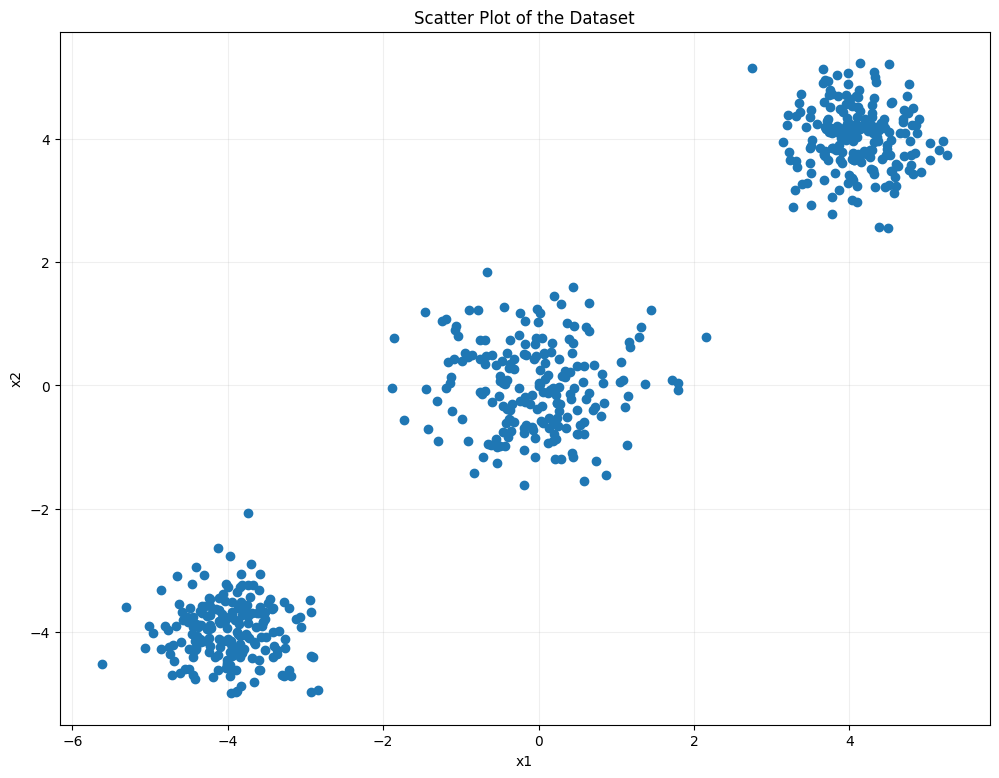

In [3]:
# Plotting the data
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=df["x1"], y=df["x2"], zorder=1)
ax.set_title("Scatter Plot of the Dataset")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax.set_axisbelow(True)
plt.grid(alpha=0.2, zorder=0)

plt.show()
plt.close()

### (b) Implementação do K-Means

In [4]:
# Distortion implementation
def distortion(data, centroids, clusters):
    distances = []
    for i in range(len(centroids)):
        members = data[clusters == i]
        curr_distances = [
            np.pow(np.linalg.norm(point - centroids[i]), 2) for point in members
        ]
        distances += curr_distances
    return sum(distances)

# K-Means implementation
def kmeans(data, k: int, max_iter: int = 1000, verbose:bool = False):
    distortions = []

    # Choose random k points as initial centroids
    centroids = data[np.random.randint(0, len(data), k)]

    # First assign every point to the closest centroid
    clusters = np.zeros(len(data))
    for i in range(len(data)):
        point = data[i]
        min_dist = np.inf
        closest_centroid = -1
        for j in range(len(centroids)):
            centroid = centroids[j]
            dist = np.linalg.norm(point - centroid)
            if dist < min_dist:
                min_dist = dist
                closest_centroid = j
        clusters[i] = closest_centroid

    # Iters until convergence
    iterations = 0
    while True:
        # Finds the optimal centroids
        for i in range(len(centroids)):
            members = data[clusters == i]
            centroids[i] = np.mean(members)

        # Finds the optimal cluster assignments
        has_changed = False
        for i in range(len(data)):
            point = data[i]
            min_dist = np.inf
            closest_centroid = -1
            for j in range(len(centroids)):
                centroid = centroids[j]
                dist = np.linalg.norm(point - centroid)
                if dist < min_dist:
                    min_dist = dist
                    closest_centroid = j
            if closest_centroid != clusters[i]:
                clusters[i] = closest_centroid
                has_changed = True

        # Logging
        dist = distortion(data, centroids, clusters)
        distortions.append(dist)
        if verbose:
            print(f"{iterations} - Distortion: {dist}")

        # Convergence criterion
        iterations += 1
        if (not has_changed) or (iterations >= max_iter):
            break

    return centroids, clusters, distortions

In [5]:
centroids, clusters, distortions = kmeans(data, 3, verbose=True)

0 - Distortion: 2817.120556024269
1 - Distortion: 635.8088043287437
2 - Distortion: 388.4183858127027


### (c) Escolha de K: Cotovelo e Silhouette

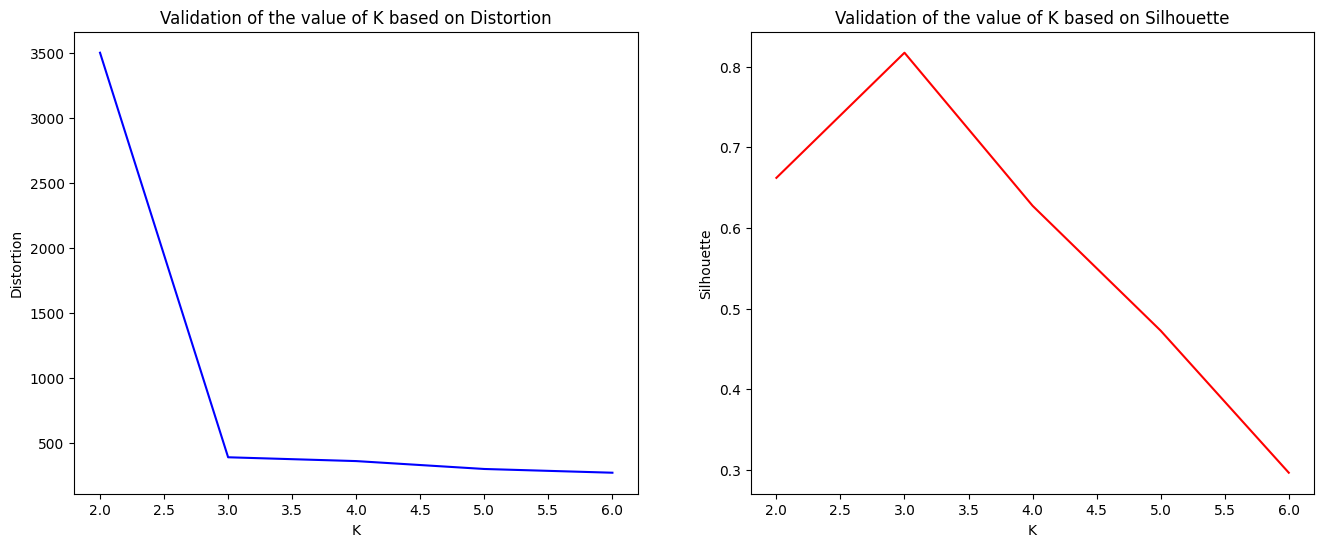

In [18]:
samples = 5
K = [2, 3, 4, 5, 6]

# Selection a value for K
distortions = []
silhoettes = []
for k in K:
    # Does various initializations to account for randomness
    # Takes the best one
    centroids = []
    clusters = []
    distort = np.inf
    for i in range(samples):
        centroids_, clusters_, distortions_ = kmeans(data, k)
        if distortions_[-1] < distort:
            centroids = centroids_
            clusters = clusters_
            distort = distortions_[-1]

    # Computes metrics
    distortions.append(distort)
    silhoettes.append(silhouette_score(data, clusters))

# Plots the validation results
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

ax[0].plot(K, distortions, color="blue", label="Distortion")
ax[0].set_title("Validation of the value of K based on Distortion")
ax[0].set_xlabel("K")
ax[0].set_ylabel("Distortion")

ax[1].plot(K, silhoettes, color="red", label="Silhouette")
ax[1].set_title("Validation of the value of K based on Silhouette")
ax[1].set_xlabel("K")
ax[1].set_ylabel("Silhouette")

plt.show()
plt.close()

A partir dos gráficos acima, é possível observar como a clusterização apresenta valor máximo de silhueta para K igual a 3, assim como o valor da distorção apresenta a sua redução máxima para essa mesma quantidade de clusters. Assim, é possível deduzir que ela é uma quantidade de clusters adequada para esta tarefa de clusterização.

### (d) Visualização dos Clusters Escolhidos

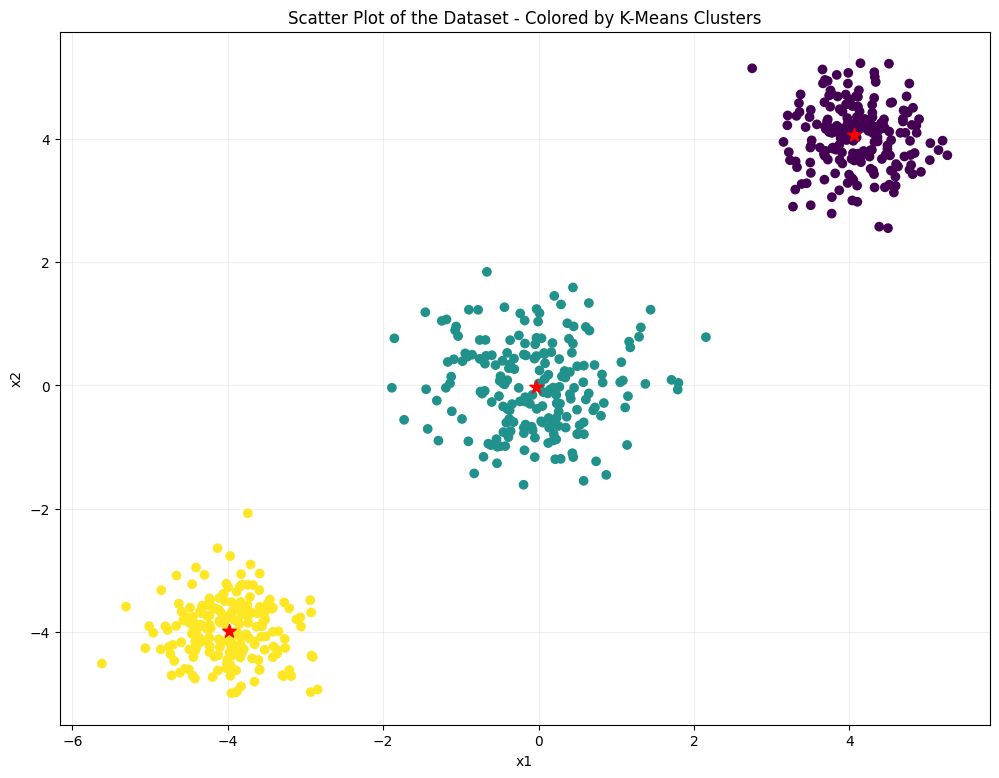

In [27]:
# Training with optimal value K = 3
centroids, clusters, distortions = kmeans(data, 3)

# Plotting the data
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=df["x1"], y=df["x2"], c=clusters, zorder=1)
ax.scatter(x=centroids[:, 0], y=centroids[:, 1], c="red", marker="*", s=100, zorder=1)
ax.set_title("Scatter Plot of the Dataset - Colored by K-Means Clusters")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax.set_axisbelow(True)
plt.grid(alpha=0.2, zorder=0)

plt.show()
plt.close()

***As estrelas indicam os centróides

### Discussão

No caso da base de dados disponibilizada, ela claramente possui três clusters bem definidos. Dessa forma, a análise de validação para o valor de K, como apresentado previamente, apresentou resultados bem acentuados, no sentido de que, para a quantidade de clusters igual a 3, a métrica de distorção e a métrica de silhueta apresentaram valores notoriamente positivos. Para valores menores que três, destaca-se como a distorção fica muito elevada, já que pontos muito distantes estão sendo colocados no mesmo cluster. Já para valores maiores que três, a distorção não é mais tão impactada, já que as divisões ocorrem dentro de cada cluster visualmente definido no gráfico acima, mas a silhueta é especialmente impactada, já que, agora, dois clusters podem estar muito próximos um do outro, de modo que pontos na borda detenham um certo fator de confusão. Isso também é confirmado pelo gráfico da silhueta, cujo valore cai bastante para mais que três clusters. Nesse sentido, pode-se pensar que a distorção e a silhueta estão atuando de maneira complementar.

O K-Means é um método de clusterização capaz apenas de encontrar fronteiras lineares de separação entre clusters. Em outras palavras, ele funciona por meio de uma partição do espaço em sub-espaços, cada um designado a um cluster, mas os quais podem apenas ser convexos. O resultado disso é que este método de clusterização funciona bem apenas quando, de fato, os dados possuem uma tendência natural de se agrupar em formas convexas, resultando em clusters aproximadamente esféricos e homogêneos. Para fronteiras de separação não-lineares, o algoritmo K-Means não funciona muito bem e outras abordagens devem ser exploradas.

## **DBSCAN:** Clustering por Densidade

In [30]:
# Reading the data
df = pd.read_csv("dados/secao2.csv")
data = df[["x1", "x2"]].to_numpy()

### (a) Visualização e Intuição

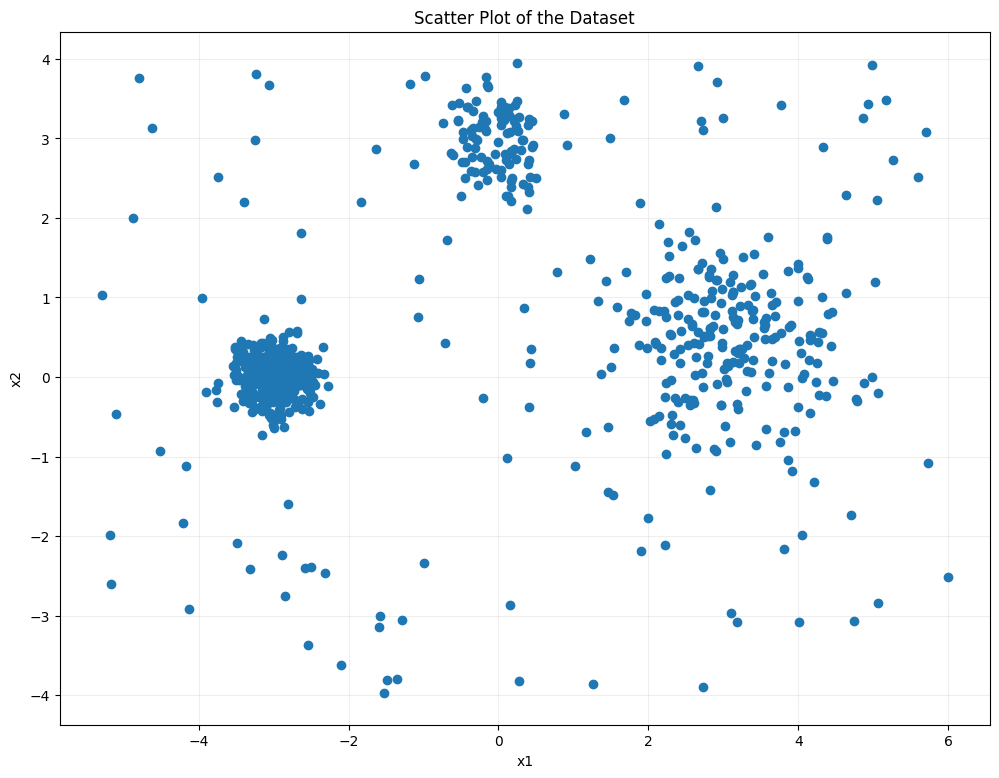

In [31]:
# Plotting the data
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=df["x1"], y=df["x2"], zorder=1)
ax.set_title("Scatter Plot of the Dataset")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax.set_axisbelow(True)
plt.grid(alpha=0.2, zorder=0)

plt.show()
plt.close()

A partir da figura acima, é possível identificar três principais agrupamentos de pontos, cada um possuindo uma densidade diferente, possivelmente representando três clusters, além de uma nuvem esparsa de pontos espalhada por todo o espaço, possivelmente representando ruído.

### (b) Clustering com DBSCAN

### EVALUATING DBSCAN eps=0.5 min_samples=100
- num_of_clusters: 1
- noise_ratio: 1.1813031161473089
- silhouette: Can't compute!

### EVALUATING DBSCAN eps=1 min_samples=30
- num_of_clusters: 3
- noise_ratio: 0.10315186246418338
- silhouette: 0.6774500636174446

### EVALUATING DBSCAN eps=3 min_samples=10
- num_of_clusters: 1
- noise_ratio: 0.0
- silhouette: Can't compute!



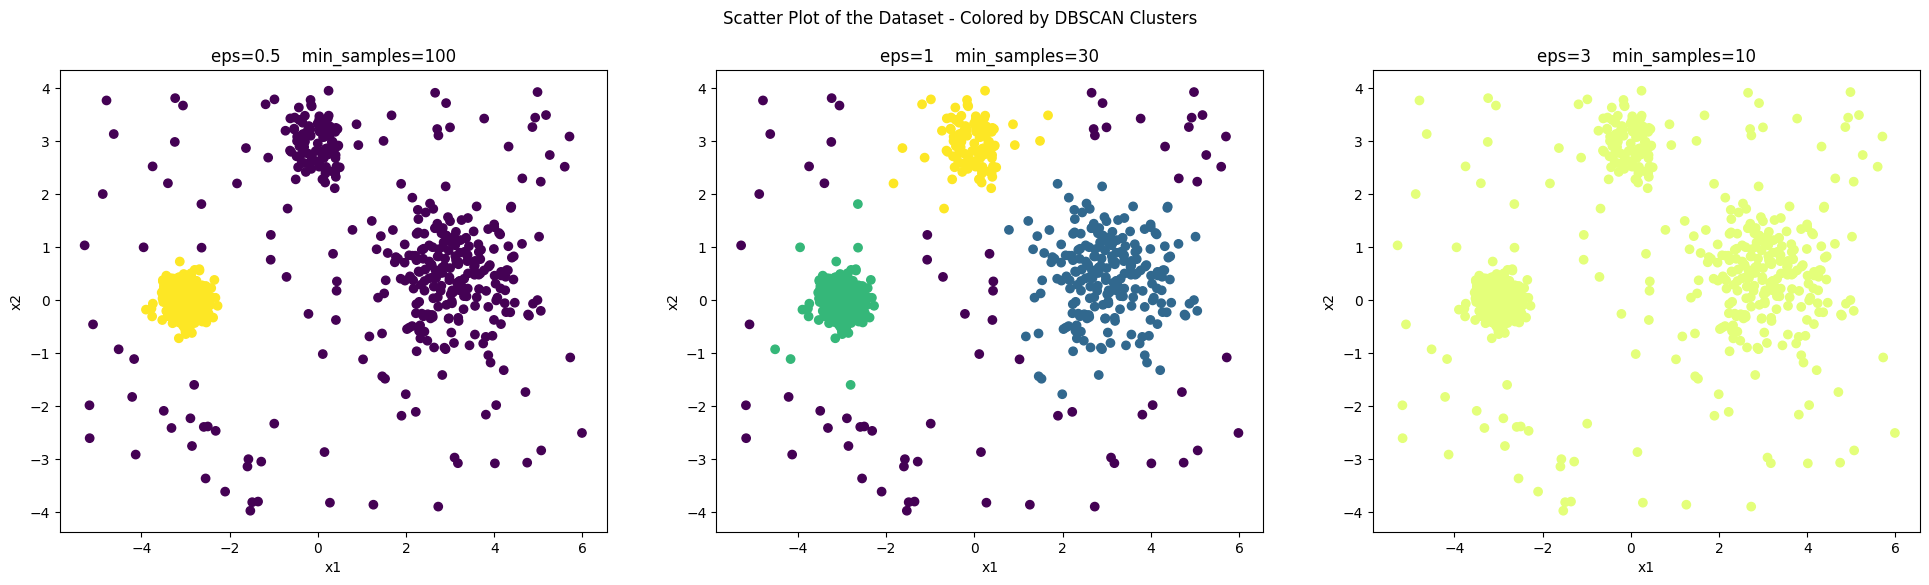

In [92]:
def evaluate_dbscan(data, labels, eps, min_samples):
    num_of_clusters = len(np.unique(labels[labels != -1]))
    noise_ratio = sum(labels == -1) / sum(labels != -1)
    if num_of_clusters > 1:
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = "Can't compute!"

    print(f"### EVALUATING DBSCAN eps={eps} min_samples={min_samples}")
    print(f"- num_of_clusters: {num_of_clusters}")
    print(f"- noise_ratio: {noise_ratio}")
    print(f"- silhouette: {silhouette}")
    print()


# Evaluating DBSCAN
clustering0 = DBSCAN(eps=0.5, min_samples=100).fit(data)
evaluate_dbscan(data, clustering0.labels_, 0.5, 100)

clustering1 = DBSCAN(eps=1, min_samples=30).fit(data)
evaluate_dbscan(data, clustering1.labels_, 1, 30)

clustering2 = DBSCAN(eps=3, min_samples=10).fit(data)
evaluate_dbscan(data, clustering2.labels_, 3, 10)

# Plotting the data
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)

ax[0].scatter(x=df["x1"], y=df["x2"], c=clustering0.labels_, zorder=1)
ax[0].set_title("eps=0.5    min_samples=100")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")

ax[1].scatter(x=df["x1"], y=df["x2"], c=clustering1.labels_, zorder=1)
ax[1].set_title("eps=1    min_samples=30")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")

ax[2].scatter(x=df["x1"], y=df["x2"], c=clustering2.labels_, cmap="Wistia", zorder=1)
ax[2].set_title("eps=3    min_samples=10")
ax[2].set_xlabel("x1")
ax[2].set_ylabel("x2")

fig.suptitle("Scatter Plot of the Dataset - Colored by DBSCAN Clusters")

plt.show()
plt.close()

Os hiperparâmetros eps e min_samples definem até que densidade o modelo será capaz de identificar um cluster. Quanto menor eps e maior min_samples, maior a densidade necessária para que um agrupamento de pontos seja considerado um cluster. Isto pode ser observado na figura acima, em que, da esquerda para a direita, eps é aumentado e min_samples e reduzido. É possível notar como apenas o cluster mais denso dentre os três é capturado na primeira figura, enquanto os três são bem definidos na segunda, enquanto, na terceira, todos os pontos são agrupados sob o mesmo cluster.

### (c) Comparação com K-Means

### EVALUATING K-MEANS K=3
- num_of_clusters: 3
- noise_ratio: No noise!
- silhouette: 0.49549078800354

### EVALUATING DBSCAN eps=1 min_samples=30
- num_of_clusters: 3
- noise_ratio: 0.10315186246418338
- silhouette: 0.6774500636174446



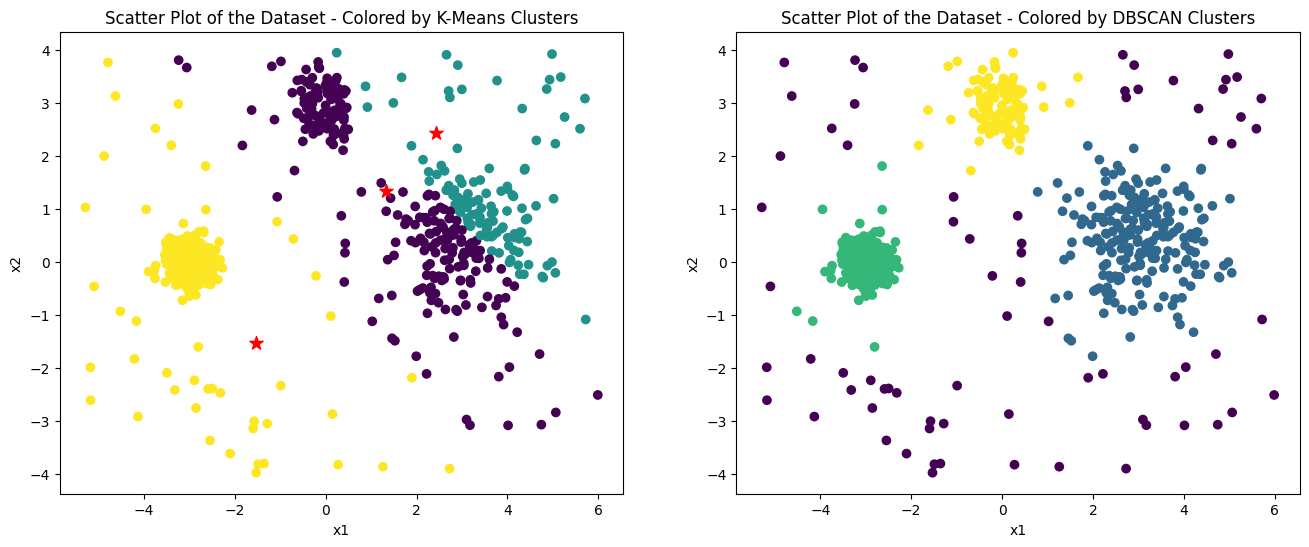

In [91]:
# K-Means training with optimal value K = 3
centroids, clusters, distortions = kmeans(data, 3)
num_of_clusters = len(np.unique(clusters))
noise_ratio = "No noise!"
silhouette = silhouette_score(data, clusters)

print("### EVALUATING K-MEANS K=3")
print(f"- num_of_clusters: {num_of_clusters}")
print(f"- noise_ratio: {noise_ratio}")
print(f"- silhouette: {silhouette}")
print()

# DBSCAN training with optimal values eps = 1 and min_samples = 30
clustering = DBSCAN(eps=1, min_samples=30).fit(data)
labels = clustering.labels_
num_of_clusters = len(np.unique(labels[labels != -1]))
noise_ratio = sum(labels == -1) / sum(labels != -1)
if num_of_clusters > 1:
    silhouette = silhouette_score(data, labels)
else:
    silhouette = "Can't compute!"

print("### EVALUATING DBSCAN eps=1 min_samples=30")
print(f"- num_of_clusters: {num_of_clusters}")
print(f"- noise_ratio: {noise_ratio}")
print(f"- silhouette: {silhouette}")
print()

# Plotting the data
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

ax[0].scatter(x=df["x1"], y=df["x2"], c=clusters)
ax[0].scatter(x=centroids[:, 0], y=centroids[:, 1], c="red", marker="*", s=100)
ax[0].set_title("Scatter Plot of the Dataset - Colored by K-Means Clusters")
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")

ax[1].scatter(x=df["x1"], y=df["x2"], c=labels)
ax[1].set_title("Scatter Plot of the Dataset - Colored by DBSCAN Clusters")
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")

plt.show()
plt.close()

A partir das visualizações acima, é possível observar qualitativamente como o DBSCAN parece ser substancialmente mais adequado para este conjunto de dados do que o K-Means. Aquele foi capaz de identificar cada um dos três agrupamentos visuais dos dados, enquanto este os separou por três fronteiras lineares estranhas, percorrendo transversalmente o espaço. De fato, olhando por um ponto de vista quantitativo, o DBSCAN também apresentou resultados melhores em termos do índice de silhueta, o qual foi maior em comparação ao K-Means.

Uma hipótese para este comportamento é justamente a robustez do DBSCAN a *outliers*. Em função de depender de métricas de distância, o K-Means é sensível a pontos muito distantes da massa principal dos dados, fazendo com que ele crie fronteiras de separação visualmente estranhas para conseguir os acomodar e manter as métricas de separação do sistema como um todo razoáveis. O resultado disto para esse conjunto de dados é justamente fronteiras que não se alinham com as concentrações de pontos. O DBSCAN, por outro lado, por ser baseado em densidade, consegue ignorar pontos muito distantes da tendência geral dos dados, tornando-o mais adequado nesta situação.

### (d) Discussão

Ao contrário do K-Means, discutido previamente, o DBSCAN baseia-se em uma noção de densidade para agrupar os dados. A ideia é que, dados alguns hiperparâmetros que controlam o quão densos os pontos devem estar agrupados, ele navega por cada ponto e encontra aqueles outros que estão próximos e agrupados o suficiente dele, colocando todos no mesmo grupo e continuando o processo, expandido as margens do grupo até que se chegue em uma região com densidade abaixo daquela definida pelos hiperparâmetros. Dessa forma, ao contrário do K-Means, o DBSCAN é capaz de encontrar fronteiras de separação não-lineares e clusters com formas orgânicas, potencialmente não-convexas.

Um detalhe interessante, já discutido, refere-se à capacidade do DBSCAN em encontrar *outliers*. No caso, esses pontos são definidos como aqueles presentes em regiões com densidade abaixo do *threshold* estabelecido para o modelo, isto é, são pontos muito dispersos uns dos outros. A análise dos resultados muda com a presença desses pontos, já que, por exemplo, para o K-Means, todo ponto pertenceria a um cluster, o que é uma hipótese forte sobre a disposição dos dados pelo espaço. Já com o DBSCAN, é possível que pontos não pertençam a cluster algum, o que acontece quando eles aparentam não possuir um agrupamento natural com os demais pontos, isto é, quando eles não estão, de fato, agrupados.

## **Spectral Clustering:** Estruturas Não-Lineares

In [95]:
# Reading the data
df = pd.read_csv("dados/secao3.csv")
data = df[["x1", "x2"]].to_numpy()

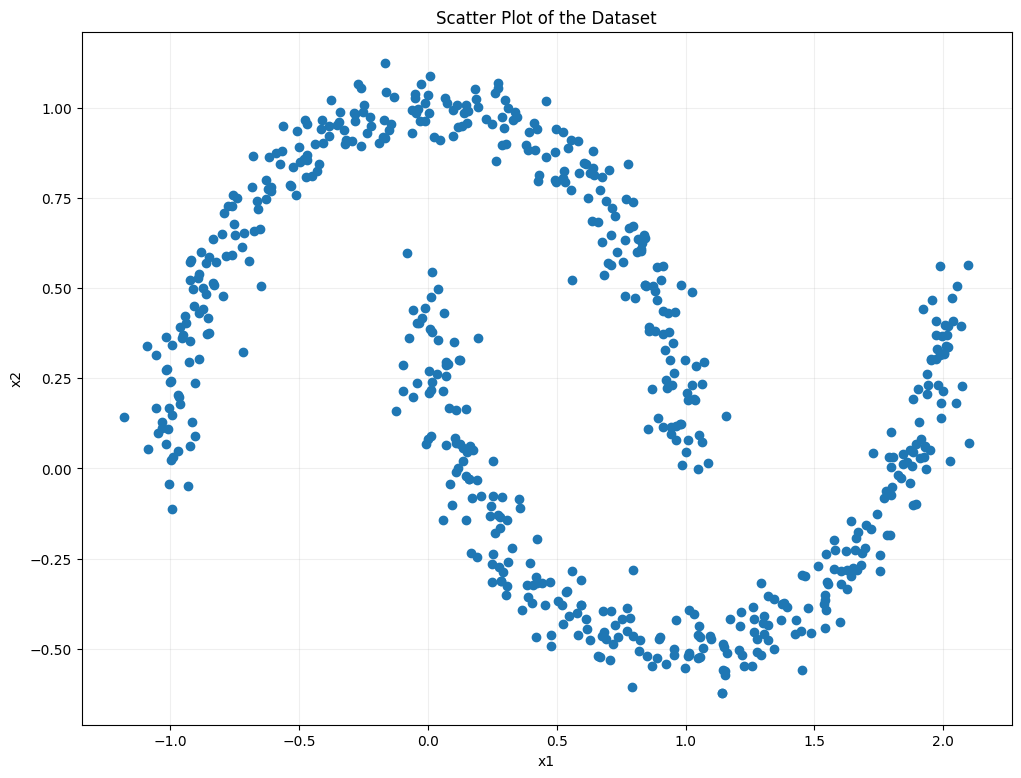

In [96]:
# Plotting the data
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=df["x1"], y=df["x2"], zorder=1)
ax.set_title("Scatter Plot of the Dataset")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax.set_axisbelow(True)
plt.grid(alpha=0.2, zorder=0)

plt.show()
plt.close()

### (a) Rodando o Spectral Clustering com Biblioteca

/home/bereis01/Personal/UFMG/Projects/MLA/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


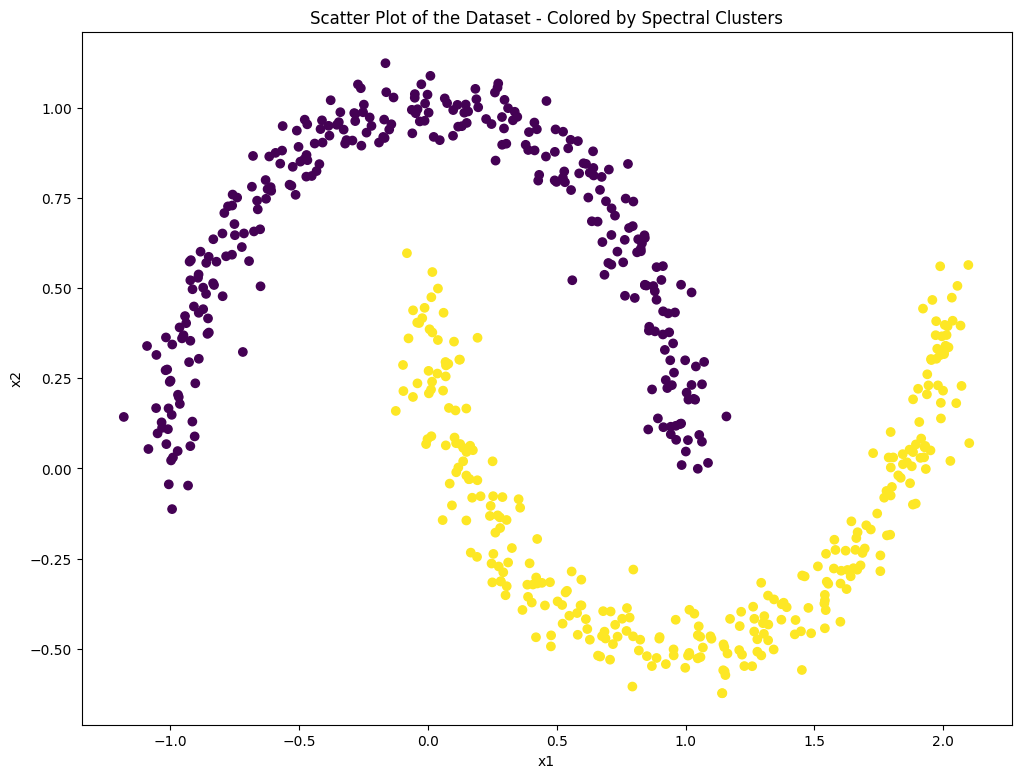

In [108]:
def evaluate_specclust(data, labels, num_clusters):
    num_of_clusters = len(np.unique(labels[labels != -1]))
    noise_ratio = sum(labels == -1) / sum(labels != -1)
    if num_of_clusters > 1:
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = "Can't compute!"

    print(f"### EVALUATING SPEC CLUST num_clusters={num_clusters}")
    print(f"- num_of_clusters: {num_of_clusters}")
    print(f"- noise_ratio: {noise_ratio}")
    print(f"- silhouette: {silhouette}")
    print()


# Evaluating Spectral Clustering
clustering = SpectralClustering(
    n_clusters=2, affinity="nearest_neighbors", random_state=RANDOM_STATE
).fit(data)

# Plotting the data
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=df["x1"], y=df["x2"], c=clustering.labels_, zorder=1)
ax.set_title("Scatter Plot of the Dataset - Colored by Spectral Clusters")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.show()
plt.close()

### (b) Comparação com K-Means no Espaço Original

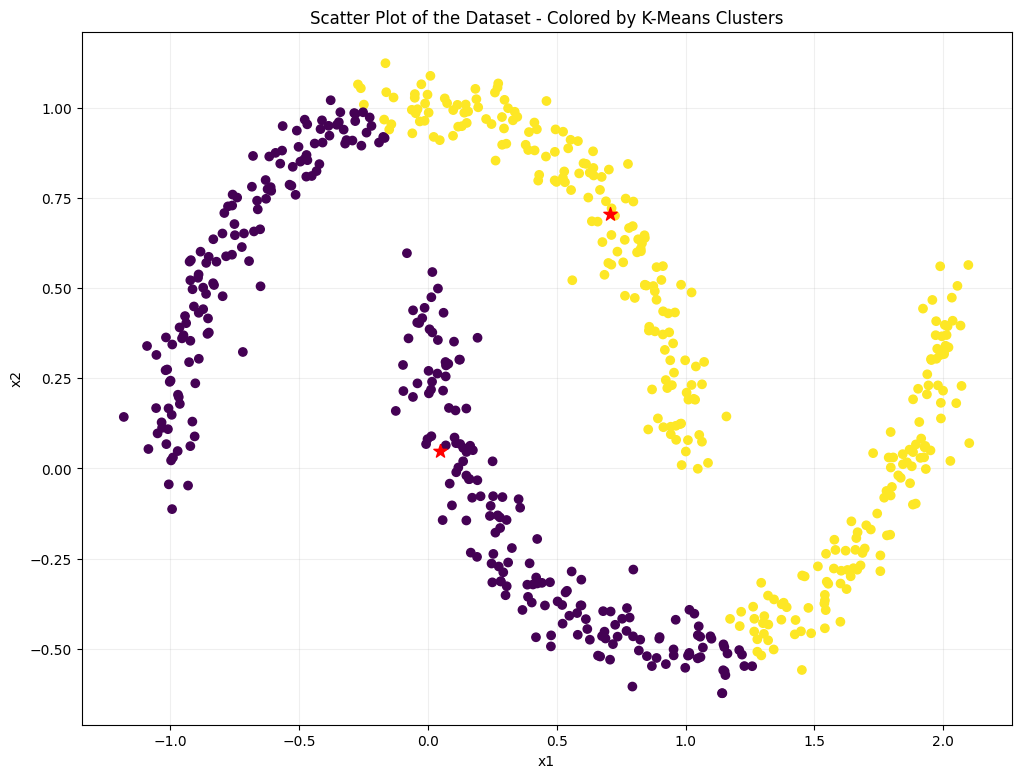

In [104]:
# Training with optimal value K = 2
centroids, clusters, distortions = kmeans(data, 2)

# Plotting the data
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=df["x1"], y=df["x2"], c=clusters, zorder=1)
ax.scatter(x=centroids[:, 0], y=centroids[:, 1], c="red", marker="*", s=100, zorder=1)
ax.set_title("Scatter Plot of the Dataset - Colored by K-Means Clusters")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

ax.set_axisbelow(True)
plt.grid(alpha=0.2, zorder=0)

plt.show()
plt.close()

In [107]:
num_of_clusters = len(np.unique(clusters))
noise_ratio = "No noise!"
silhouette = silhouette_score(data, clusters)
print(f"### EVALUATING K-MEANS K={num_of_clusters}")
print(f"- num_of_clusters: {num_of_clusters}")
print(f"- noise_ratio: {noise_ratio}")
print(f"- silhouette: {silhouette}")
print()

evaluate_specclust(data, clustering.labels_, 2)

### EVALUATING K-MEANS K=2
- num_of_clusters: 2
- noise_ratio: No noise!
- silhouette: 0.2968194484208515

### EVALUATING SPEC CLUST num_clusters=2
- num_of_clusters: 2
- noise_ratio: 0.0
- silhouette: 0.33449829466418285



É possível observar a partir dos resultados acima a limitação do algoritmo K-Means em encontrar fronteiras de separação não-lineares. Visualmente, fica nítido que os dados apresentam dois principais agrupamentos. Porém, como é possível notar no gráfico dos resultados do K-Means, de fato, foi gerada uma fronteira de agrupamento linear que, no caso, é ótima, no sentido de que provavelmente minimiza a distância entre os pontos e o seu centróide considerando apenas fronteiras lineares, mas que não é adequada para este problema na prática. Por outro lado, o Spectral Clustering foi capaz de adequadamente identificar os dois agrupamentos por meio de uma fronteira de separação não-linear.

### (c) Explorando Hiperparâmetros e Afinidade

/home/bereis01/Personal/UFMG/Projects/MLA/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/bereis01/Personal/UFMG/Projects/MLA/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/bereis01/Personal/UFMG/Projects/MLA/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/bereis01/Personal/UFMG/Projects/MLA/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


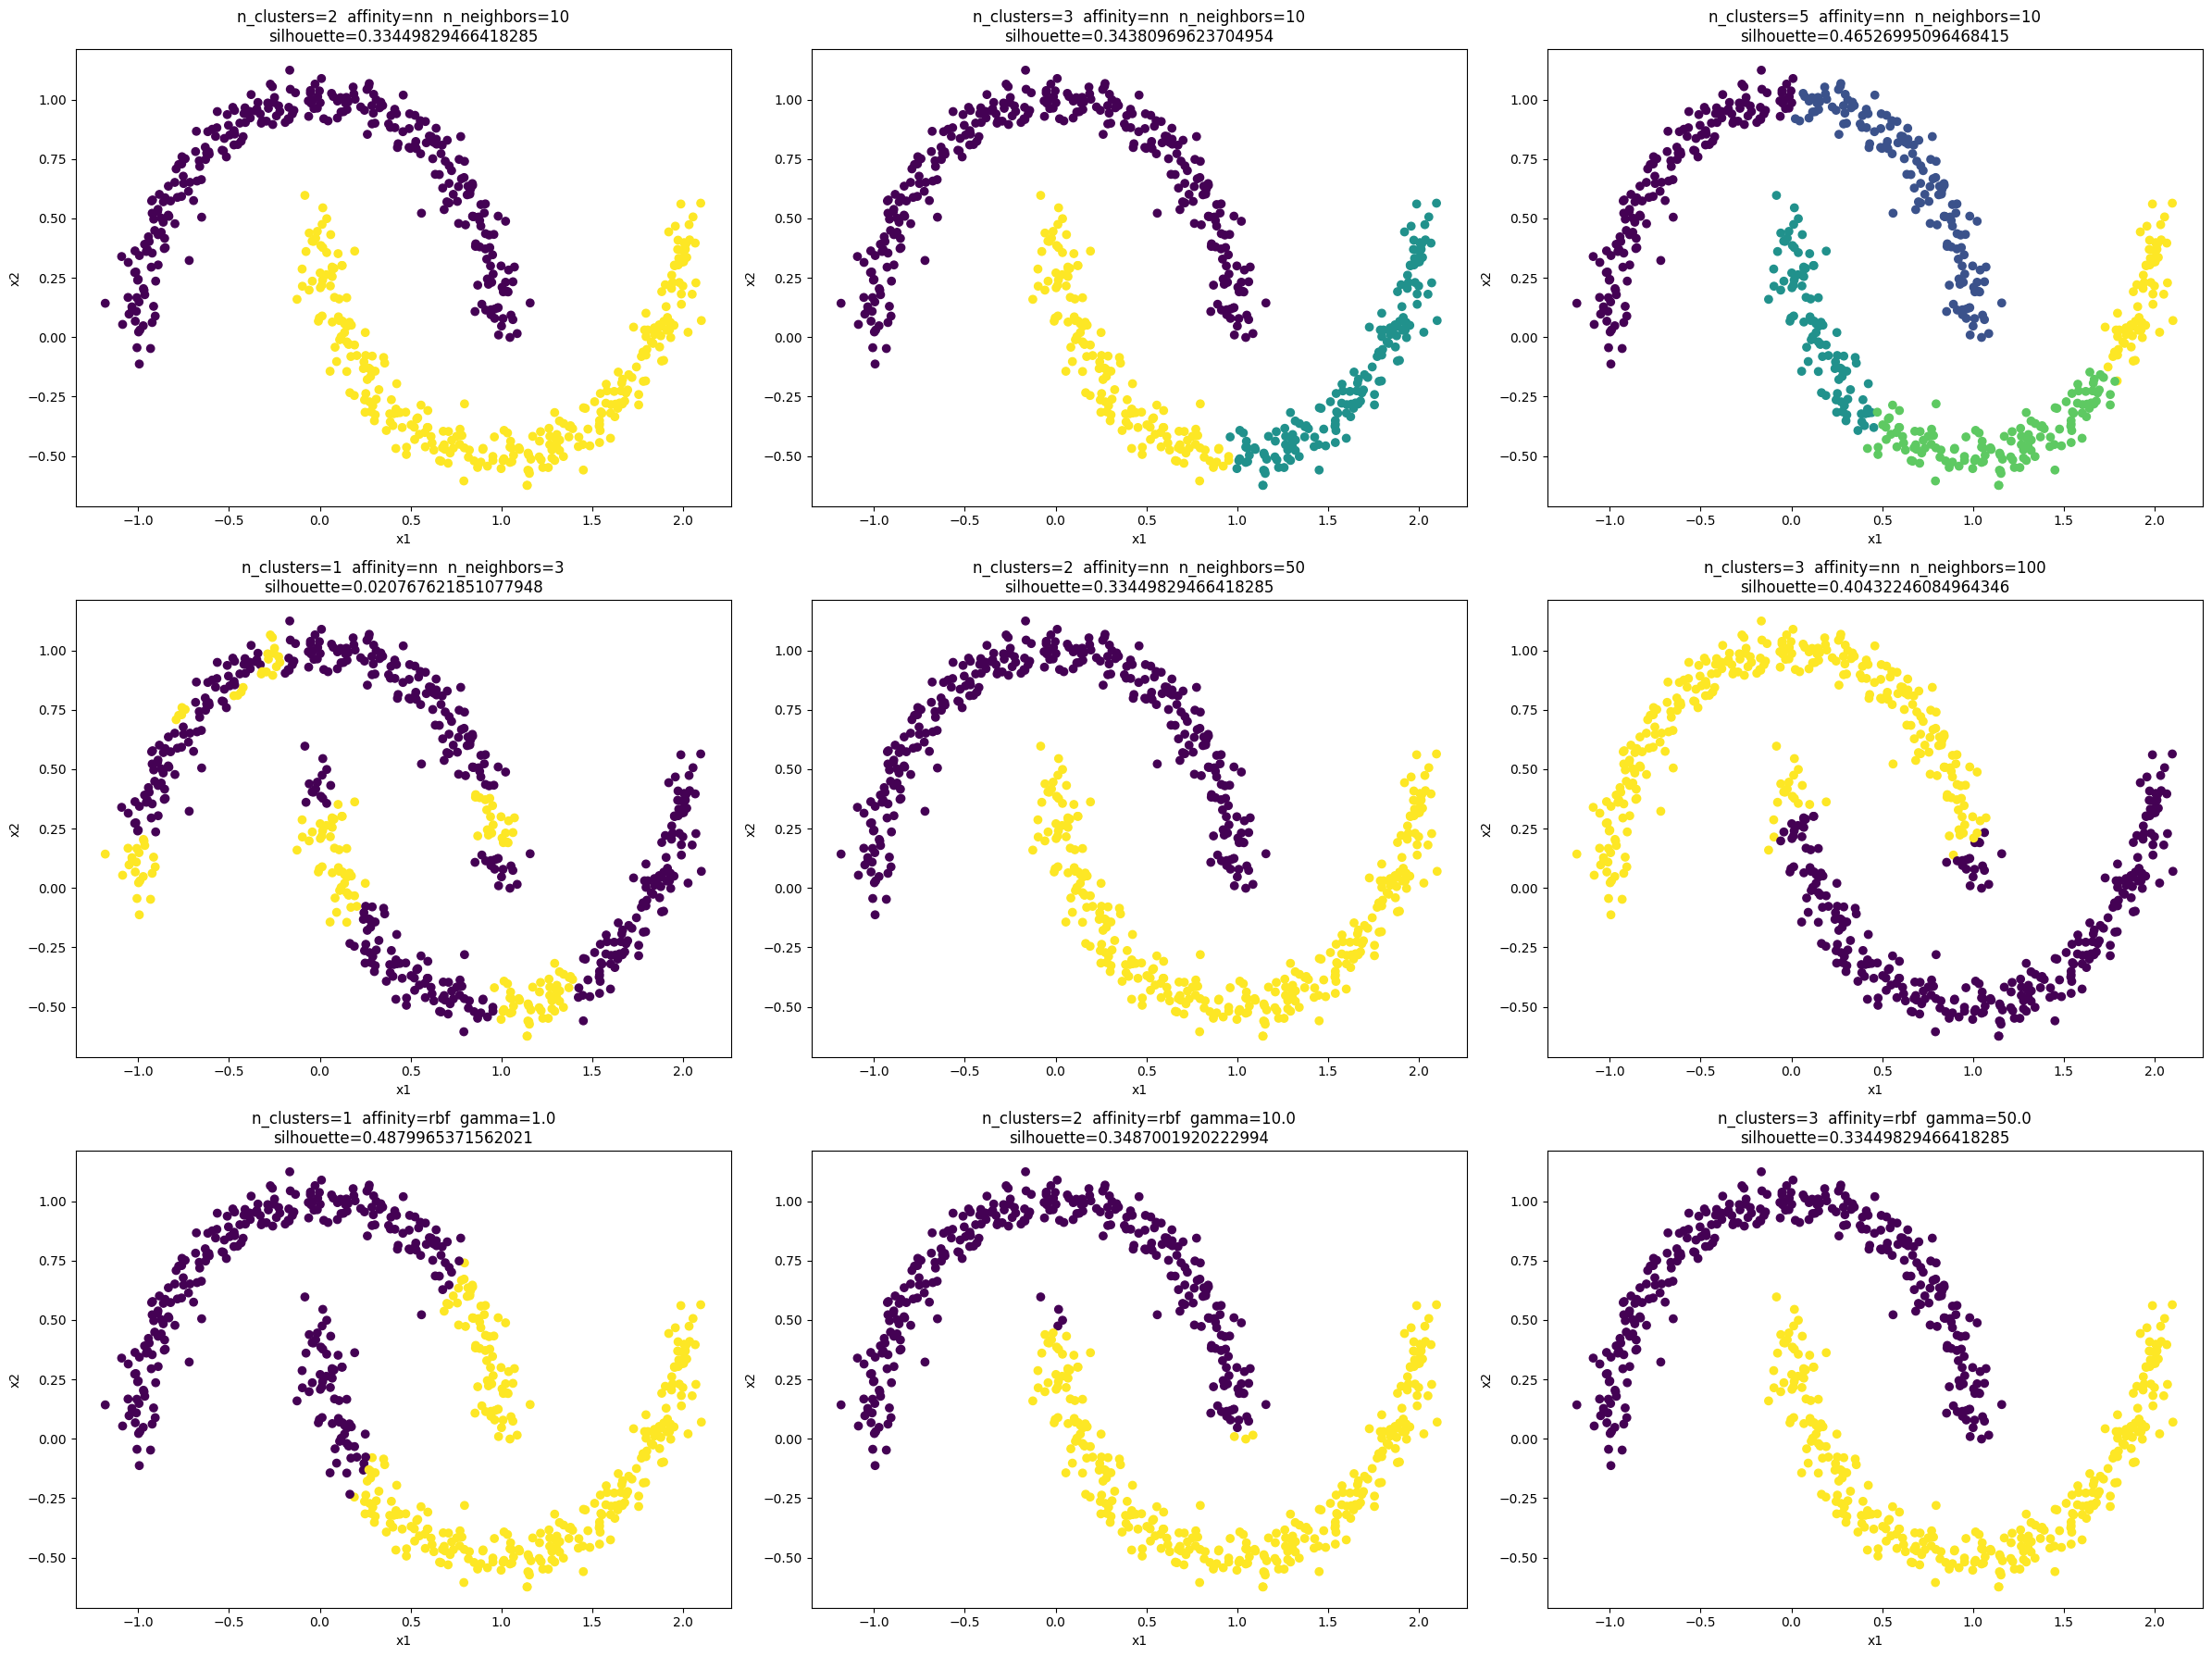

In [135]:
# Plotting the data
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(24, 18)

# Varying number of clusters

clustering = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=10,
    gamma=1.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[0][0].scatter(x=df["x1"], y=df["x2"], c=clustering.labels_)
ax[0][0].set_title(
    f"n_clusters=2  affinity=nn  n_neighbors=10\nsilhouette={silhouette}"
)
ax[0][0].set_xlabel("x1")
ax[0][0].set_ylabel("x2")

clustering = SpectralClustering(
    n_clusters=3,
    affinity="nearest_neighbors",
    n_neighbors=10,
    gamma=1.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[0][1].scatter(x=df["x1"], y=df["x2"], c=clustering.labels_)
ax[0][1].set_title(
    f"n_clusters=3  affinity=nn  n_neighbors=10\nsilhouette={silhouette}"
)
ax[0][1].set_xlabel("x1")
ax[0][1].set_ylabel("x2")

clustering = SpectralClustering(
    n_clusters=5,
    affinity="nearest_neighbors",
    n_neighbors=10,
    gamma=1.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[0][2].scatter(
    x=df["x1"],
    y=df["x2"],
    c=clustering.labels_,
)
ax[0][2].set_title(
    f"n_clusters=5  affinity=nn  n_neighbors=10\nsilhouette={silhouette}"
)
ax[0][2].set_xlabel("x1")
ax[0][2].set_ylabel("x2")

# Varying n_neighbors

clustering = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=3,
    gamma=1.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[1][0].scatter(x=df["x1"], y=df["x2"], c=clustering.labels_)
ax[1][0].set_title(f"n_clusters=1  affinity=nn  n_neighbors=3\nsilhouette={silhouette}")
ax[1][0].set_xlabel("x1")
ax[1][0].set_ylabel("x2")

clustering = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=50,
    gamma=1.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[1][1].scatter(x=df["x1"], y=df["x2"], c=clustering.labels_)
ax[1][1].set_title(
    f"n_clusters=2  affinity=nn  n_neighbors=50\nsilhouette={silhouette}"
)
ax[1][1].set_xlabel("x1")
ax[1][1].set_ylabel("x2")

clustering = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=100,
    gamma=1.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[1][2].scatter(
    x=df["x1"],
    y=df["x2"],
    c=clustering.labels_,
)
ax[1][2].set_title(
    f"n_clusters=3  affinity=nn  n_neighbors=100\nsilhouette={silhouette}"
)
ax[1][2].set_xlabel("x1")
ax[1][2].set_ylabel("x2")

# Varying kernel in rbf

clustering = SpectralClustering(
    n_clusters=2,
    affinity="rbf",
    n_neighbors=10,
    gamma=1.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[2][0].scatter(x=df["x1"], y=df["x2"], c=clustering.labels_)
ax[2][0].set_title(f"n_clusters=1  affinity=rbf  gamma=1.0\nsilhouette={silhouette}")
ax[2][0].set_xlabel("x1")
ax[2][0].set_ylabel("x2")

clustering = SpectralClustering(
    n_clusters=2,
    affinity="rbf",
    n_neighbors=10,
    gamma=10.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[2][1].scatter(x=df["x1"], y=df["x2"], c=clustering.labels_)
ax[2][1].set_title(f"n_clusters=2  affinity=rbf  gamma=10.0\nsilhouette={silhouette}")
ax[2][1].set_xlabel("x1")
ax[2][1].set_ylabel("x2")

clustering = SpectralClustering(
    n_clusters=2,
    affinity="rbf",
    n_neighbors=10,
    gamma=50.0,
    random_state=RANDOM_STATE,
).fit(data)
silhouette = silhouette_score(data, clustering.labels_)

ax[2][2].scatter(
    x=df["x1"],
    y=df["x2"],
    c=clustering.labels_,
)
ax[2][2].set_title(f"n_clusters=3  affinity=rbf  gamma=50.0\nsilhouette={silhouette}")
ax[2][2].set_xlabel("x1")
ax[2][2].set_ylabel("x2")

fig.tight_layout()

plt.show()
plt.close()

Nos gráficos acima:
- A primeira linha varia a quantidade de clusters, mantendo a afinidade igual a vizinhos mais próximos e a quantidade de vizinhos igual a 10;
- A segunda linha varia a quantidade de vizinhos mais próximos, mantendo a quantidade de clusters igual a 2;
- A terceira linha utiliza a afinidade RBF e varia gamma, mantendo a quantidade de clusters igual a 2;

É possível observar que, na primeira linha, os melhores resultados visuais são obtidos com o número de clusters igual a 2, porém a melhor silhueta é obtida com número de clusters igual a 5. Este resultado é extremamente interessante e talvez revele uma inadequação desta métrica a clusters não lineares. O mesmo efeito acontece para as demais linhas, nas quais o melhor clustering em silhueta não é o melhor clustering em uma análise qualitativa visual. Na segunda linha, o melhor clustering é obtido com uma quantidade de vizinhos igual a 50, enquanto, na terceira linha, o melhor clustering é obtido com gamma igual a 50.0.

### (d) Interpretando o Embedding Espacial

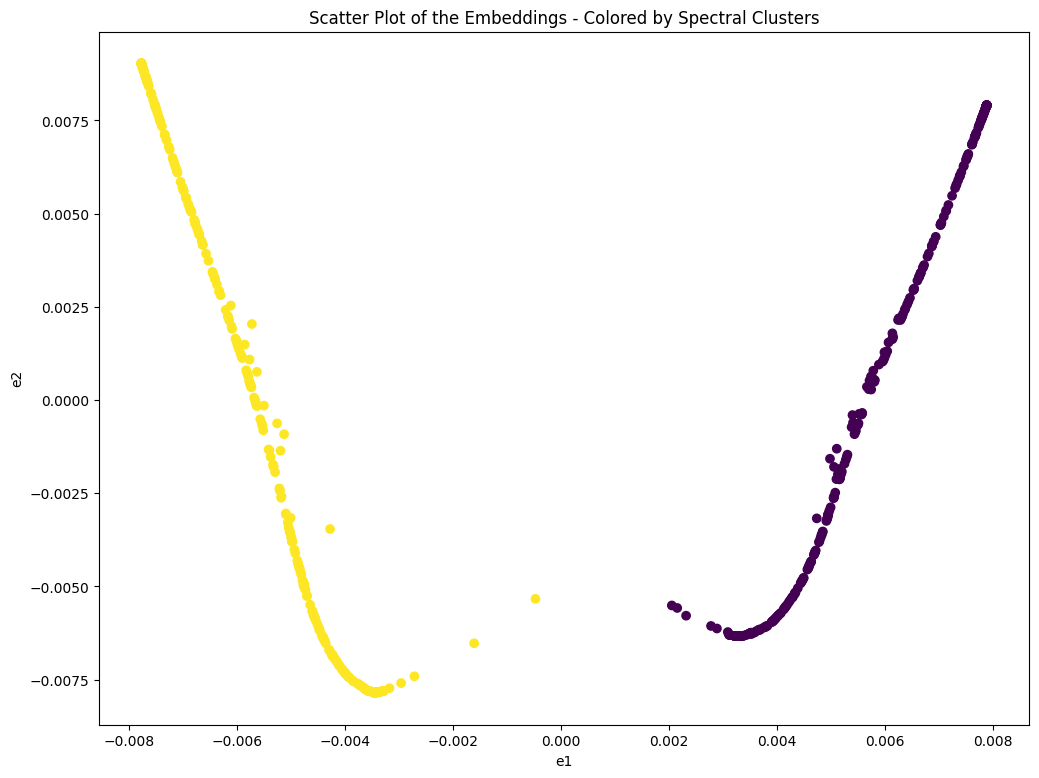

In [152]:
# Evaluating Spectral Clustering
clustering = SpectralClustering(
    n_clusters=2,
    affinity="nearest_neighbors",
    n_neighbors=50,
    random_state=RANDOM_STATE,
).fit(data)
embedding = SpectralEmbedding(
    n_components=2,
    affinity="nearest_neighbors",
    n_neighbors=50,
    random_state=RANDOM_STATE,
).fit_transform(data)

# Plotting the data
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=embedding[:, 0], y=embedding[:, 1], c=clustering.labels_)
ax.set_title("Scatter Plot of the Embeddings - Colored by Spectral Clusters")
ax.set_xlabel("e1")
ax.set_ylabel("e2")

plt.show()
plt.close()

A partir da visualização acima, é possível observar como, de fato, no espaço de *embeddings* da decomposição espectral, baseada em uma matriz de afinidade entre os pontos, as instâncias se apresentam linearmente separáveis, em comparação à fronteira não-linear existente nos dados originais. Dessa forma, agora, é possível aplicar algoritmos como o K-Means e se obter bons resultados.

### (e) Discussão

A ideia do Spectral Clustering consiste em, primeiro, construir uma matriz de afinidades entre os dados, a qual captura em grande medida o relacionamento de cada ponto com cada outro em termos de uma métrica de similaridade, e, em seguida, construir uma nova representação para cada ponto que maximize o agrupamento entre pontos próximos e a separação entre pontos distantes. Uma maneira de pensar nesse processo seria que os dados são projetados em um novo espaço, construído com base em suas distâncias no espaço original, no qual o seu nível de separação é reforçado. Nesse novo espaço, possivelmente, os diferentes grupos de pontos são linearmente separáveis, de modo que a aplicação de um algoritmo como o K-Means leve a bons resultados, em oposição ao espaço original, no qual essas fronteiras eram não-lineares. 

A afinidade e seus demais hiperparâmetros são fundamentais no bom comportamento do Spectral Clustering, já que definem justamente a maneira como essa projeção irá ocorrer, potencialmente reforçando ou inibindo a distribuição espacial natural dos dados em função de uma métrica de similaridade. Em outras palavras, os hiperparâmetros vão determinar quais pontos são próximos (e, portanto, devem ser mais agrupados no novo espaço) e quais pontos são distantes (e, portanto, devem ser separados no novo espaço).

Entretanto, o Spectral Clustering possui algumas limitações práticas, principalmente relacionadas a sua complexidade. Em particular, observa-se que, em uma implementação ingênua, é necessário computar a afinidade de cada ponto com cada outro, resultando em uma matriz $n*n$. Além disso, após o processo de *embedding*, ainda é necessário aplicar o método de clusterização propriamente dito. Dessa forma, esse algoritmo pode não se comportar muito bem para conjuntos de dados muito grandes. Apenas para referência, o K-Means exige apenas $n * n°clusters * n°iterations$ computações.